# Policy Gradients
### Introduction
On this notebook we will train a policy network to solve a particular problem on the OpenAI Environment. We will train this policy network with the REINFORCE algorithm.
![alt text](imgs/policy_stochastic.png "Game")

#### REINFORCE Algorithm
#### Short Introduction
The REINFORCE algorithm is one implementation of the Policy Gradient family of algorithms, the idea of the algorithm is to have the policy represented by a neural network with $\theta$ parameters. The main idea of the algorithm is to change the network parameters to make the actions that provided positive rewards to be more probable to happen. The training phase optimize the following loss function:
$$\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$$
Where:
* $\hat{Q}(s,a)$: It's an estimate of the state action function, that will modulate the probability of good actions to happen more often.
* $\pi_{\theta}(a|s)$: It's the neural network that represent the policy and returns an distribution of actions given an state.

The steps of the algorithm
1. Initialize Network at random
2. Play N episodes saving their transitions "k" (s,a,r,s')
3. For every episode calculate $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
4. Perform SGD to minimize the loss: $\mathcal{L}=-\hat{Q}(s,a).log\pi_{\theta}(a|s)$
5. Repeat 2 until convergence 

#### Disadvantages of Policy Gradients
* Full episodes are required, we need to wait a full episode to complete
* High Gradients Variance: This issue can be handled by subtracting a baseline from the Value estimation
* Exploration: The agent can converge to a local-optimal area and won't explore efficiently anymore. This can be solved by the Entropy Bonus technique that basically subtract the entropy of the policy from the loss function.
* Correlation between samples: This can be remedy by using parallel environments with same policy and using the experiences from different environments to train the policy.
* Less sample efficient: To deal with this we need another algorithm (Actor-Critic)

The image bellow can highlight the full episodic issue, where we have 2 trajectories where one or more actions could be bad, but as the final total score is good those bad actions will be averaged. That's one of the reasons why Policy Gradient methods are less sample efficient.
![alt text](imgs/episode_problem.png "Game")

#### Cartpole Rules
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

#### References
* https://www.youtube.com/watch?v=tqrcjHuNdmQ
* http://karpathy.github.io/2016/05/31/rl/
* https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf
* https://leimao.github.io/article/REINFORCE-Policy-Gradient/
* https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c
* https://medium.freecodecamp.org/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f
* https://gist.github.com/tamlyn/a9d2b3990f9dab0f82d1dfc1588c876a
* http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/
* https://www.youtube.com/watch?v=iOh7QUZGyiU&list=PLqYmG7hTraZDNJre23vqCGIVpfZ_K2RZs
* https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html
* https://medium.com/@gabogarza/deep-reinforcement-learning-policy-gradients-8f6df70404e6
* https://towardsdatascience.com/learning-to-drive-smoothly-in-minutes-450a7cdb35f4
* http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture14.pdf
* https://fosterelli.co/entropy-loss-for-reinforcement-learning

### Import Libraries

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

### Initialize Environment and Hyper parameters

In [2]:
#env = gym.make('CartPole-v1')
# Uncomment for this environment (takes longer to train)
env = gym.make('LunarLander-v2')
env.seed(1)
torch.manual_seed(1)

# Hyperparameters
learning_rate = 0.01
entropy_beta = 0.01
gamma = 0.99
num_episodes=1500

# Show some information from the environment
print('Amount of rewards consider as win:', env.spec.reward_threshold)
print('Action space:', env.action_space.n)
print('Observation space:', env.observation_space.shape)
print('Reward range:', env.reward_range)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Amount of rewards consider as win: 200
Action space: 4
Observation space: (8,)
Reward range: (-inf, inf)


/Users/leonardo_a/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


### Policy Network
Define the policy Neural Network, which inputs will be the state and output an action

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.n
        num_hidden = 128

        self.FC1 = nn.Linear(state_space, num_hidden, bias=False)
        self.FC2 = nn.Linear(num_hidden, action_space, bias=False)

        # Overall reward and loss history (Just for plotting training information)
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy log probability(action) and reward history
        self.episode_log_prob_actions = torch.Tensor([])
        self.episode_log_prob_actions_dist = torch.Tensor([])
        self.episode_prob_actions = torch.Tensor([])
        self.episode_rewards = []

    def forward(self, x, keep_history=False):
        # Convert state to tensor
        state = torch.from_numpy(x).type(torch.FloatTensor)
        model = torch.nn.Sequential(
            self.FC1,
            nn.Dropout(p=0.5),
            nn.ReLU(),
            self.FC2,
            nn.Softmax(dim=-1)
        )
        
        # Execute model and sample it's outputs
        action_probs = model(state)
        distribution = Categorical(action_probs)
        action = distribution.sample()
        
        #print('action_probs:', action_probs.size())
        #print('distribution.log_prob:', distribution.log_prob(action).size())
        #print('F.log_prob(action_probs):', torch.log(action_probs).size())
        
        # Concatenate log probability of the action to be used on the loss function
        if keep_history:
            self.episode_log_prob_actions = torch.cat([self.episode_log_prob_actions, 
                                                     distribution.log_prob(action).reshape(1)])
            self.episode_log_prob_actions_dist = torch.cat([self.episode_log_prob_actions_dist, 
                                                     torch.log(action_probs)])
            self.episode_prob_actions = torch.cat([self.episode_prob_actions, action_probs])
        
        return action.item()

In [4]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

### Define the update policy function
This function is called after we gather a complete episode, and it does the following tasks:
1. Calculate the discounted Rewards: $\hat{Q}(s,a)=\sum_{i=0} \gamma^i r_i$
2. Calculate the baseline (rewards mean) and normalize the discounted rewards
3. Calculate the entropy loss (Optional)
4. Calculate the Policy loss
5. Calculate the complete loss
6. Do the loss backpropagation (Pytorch)

In [5]:
def update_policy(use_baseline = False, use_entropy = False):
    R = 0
    rewards = []

    # Discount future rewards starting from the most recent reward backwards
    for r in reversed(policy.episode_rewards):
        R = r + gamma * R
        rewards.insert(0, R)

    # Scale rewards to make the advantage be 1/-1 (Zero-mean Unit variance)
    # This is one of multiple ways to implement the advantage, for example if you use another network
    # to learn the advantage this will become the actor-critic algorithm.
    rewards = torch.FloatTensor(rewards)
    
    if use_baseline:
        baseline = rewards.mean()
        # Calculate the value estimation with a baseline (Without the baseline will be harder to converge)
        Q_estim = (rewards - baseline) / (rewards.std() + np.finfo(np.float32).eps)
    else:
        Q_estim = rewards

    # Calculate the entropy 
    entropy_loss = -entropy_beta * (torch.sum(policy.episode_prob_actions * policy.episode_log_prob_actions_dist))
    
    # Calculate the policy loss
    police_loss = torch.sum(-Q_estim * policy.episode_log_prob_actions)
    
    if use_entropy:
        # Calculate loss log_prob(action) * rewards
        loss = police_loss - entropy_loss    
    else:
        loss = police_loss

    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.episode_rewards))
    policy.reset()

### Check untrained Policy

In [6]:
state = env.reset()

for time in range(50):
    # Get an action from the Policy
    action = policy(state)

    # Render screen
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    

### Train on the Environment

In [7]:
%%time
length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()

    for time in range(1000):
        # Get an action from the Policy and keep the historical data
        action = policy(state, keep_history=True)

        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)

        # Save reward
        policy.episode_rewards.append(reward)
        rewards_episode.append(reward)
        if done:
            break

    # Calculate score to determine when the environment has been solved
    length_episode.append(time)
    mean_length_episode = np.mean(length_episode[-100:])
    mean_rewards_episode = np.mean(rewards_episode)
    
    # Calculate the discounted rewards on the episode, calculate loss and backpropagate
    update_policy()

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 79.00 Average Rewards -2.47
Episode 50	Average length (last 100 episodes): 100.55 Average Rewards -2.88
Episode 100	Average length (last 100 episodes): 104.76 Average Rewards -2.64
Episode 150	Average length (last 100 episodes): 97.96 Average Rewards -2.44
Episode 200	Average length (last 100 episodes): 81.85 Average Rewards -2.39
Episode 250	Average length (last 100 episodes): 74.78 Average Rewards -2.37
Episode 300	Average length (last 100 episodes): 71.15 Average Rewards -2.37
Episode 350	Average length (last 100 episodes): 68.55 Average Rewards -2.41
Episode 400	Average length (last 100 episodes): 67.71 Average Rewards -2.43
Episode 450	Average length (last 100 episodes): 69.47 Average Rewards -2.44
Episode 500	Average length (last 100 episodes): 70.52 Average Rewards -2.43
Episode 550	Average length (last 100 episodes): 70.07 Average Rewards -2.45
Episode 600	Average length (last 100 episodes): 70.00 Average Rewards -2.46
Episode 650	A

### Plot Training information

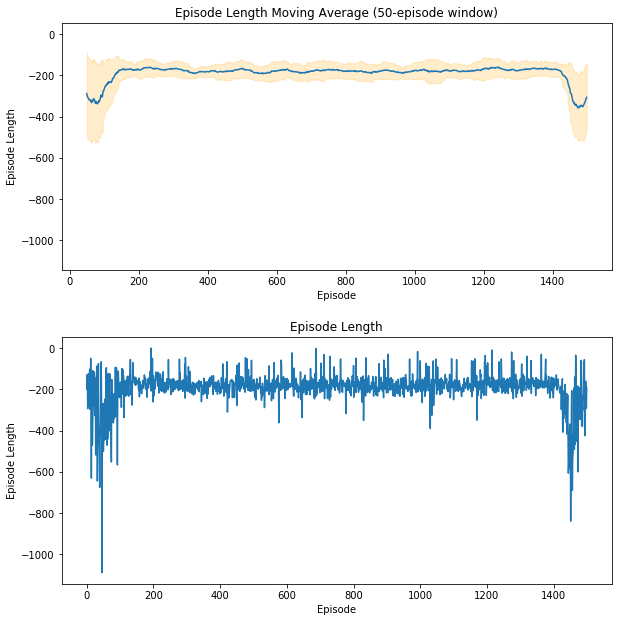

In [8]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()


### Test the Trained Policy

In [9]:
state = env.reset()

for time in range(1000):
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break

### Improving sample efficiency
Policy Gradient algorithms are already sample-efficiency worse than value based algorithms. Calculating a baseline and subtracting from your value estimate $\hat{Q}$ will improve sample efficiency. Here is a list of poossible choices for baselines:
* Some constant value, for example the mean of the discounted rewards
* Moving average of discounted rewards
* Value of state V(s)
Also depending if we use anohter network to learn out baseline we will be working on the Actor-Critic family o algorithms.

In [10]:
%%time
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()

    for time in range(1000):
        # Get an action from the Policy and keep the historical data
        action = policy(state, keep_history=True)

        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)

        # Save reward
        policy.episode_rewards.append(reward)
        rewards_episode.append(reward)
        if done:
            break

    # Calculate score to determine when the environment has been solved
    length_episode.append(time)
    mean_length_episode = np.mean(length_episode[-100:])
    mean_rewards_episode = np.mean(rewards_episode)
    
    # Calculate the discounted rewards on the episode, calculate loss and backpropagate
    update_policy(use_baseline=True)

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 88.00 Average Rewards -4.76
Episode 50	Average length (last 100 episodes): 134.71 Average Rewards -2.05
Episode 100	Average length (last 100 episodes): 162.50 Average Rewards -1.20
Solved after 114 episodes! Running average is now 202.53. Last episode ran to 999 time steps.
Solved after 115 episodes! Running average is now 203.71. Last episode ran to 206 time steps.
Solved after 116 episodes! Running average is now 205.1. Last episode ran to 216 time steps.
Solved after 117 episodes! Running average is now 214.25. Last episode ran to 999 time steps.
Solved after 118 episodes! Running average is now 222.64. Last episode ran to 999 time steps.
Solved after 119 episodes! Running average is now 223.68. Last episode ran to 254 time steps.
Solved after 120 episodes! Running average is now 223.13. Last episode ran to 193 time steps.
Solved after 121 episodes! Running average is now 225.4. Last episode ran to 308 time steps.
Solved after 122 episod

Solved after 199 episodes! Running average is now 448.86. Last episode ran to 391 time steps.
Episode 200	Average length (last 100 episodes): 452.81 Average Rewards -0.43
Solved after 200 episodes! Running average is now 452.81. Last episode ran to 573 time steps.
Solved after 201 episodes! Running average is now 447.85. Last episode ran to 503 time steps.
Solved after 202 episodes! Running average is now 450.69. Last episode ran to 475 time steps.
Solved after 203 episodes! Running average is now 455.91. Last episode ran to 688 time steps.
Solved after 204 episodes! Running average is now 460.34. Last episode ran to 638 time steps.
Solved after 205 episodes! Running average is now 466.36. Last episode ran to 768 time steps.
Solved after 206 episodes! Running average is now 471.72. Last episode ran to 695 time steps.
Solved after 207 episodes! Running average is now 467.54. Last episode ran to 581 time steps.
Solved after 208 episodes! Running average is now 474.47. Last episode ran to

Solved after 285 episodes! Running average is now 699.02. Last episode ran to 528 time steps.
Solved after 286 episodes! Running average is now 703.83. Last episode ran to 683 time steps.
Solved after 287 episodes! Running average is now 707.12. Last episode ran to 999 time steps.
Solved after 288 episodes! Running average is now 715.54. Last episode ran to 999 time steps.
Solved after 289 episodes! Running average is now 720.16. Last episode ran to 649 time steps.
Solved after 290 episodes! Running average is now 723.37. Last episode ran to 547 time steps.
Solved after 291 episodes! Running average is now 726.66. Last episode ran to 581 time steps.
Solved after 292 episodes! Running average is now 731.55. Last episode ran to 746 time steps.
Solved after 293 episodes! Running average is now 734.91. Last episode ran to 447 time steps.
Solved after 294 episodes! Running average is now 733.66. Last episode ran to 664 time steps.
Solved after 295 episodes! Running average is now 734.85. La

Solved after 371 episodes! Running average is now 499.14. Last episode ran to 665 time steps.
Solved after 372 episodes! Running average is now 499.8. Last episode ran to 622 time steps.
Solved after 373 episodes! Running average is now 500.15. Last episode ran to 636 time steps.
Solved after 374 episodes! Running average is now 500.71. Last episode ran to 725 time steps.
Solved after 375 episodes! Running average is now 497.42. Last episode ran to 670 time steps.
Solved after 376 episodes! Running average is now 497.42. Last episode ran to 695 time steps.
Solved after 377 episodes! Running average is now 499.84. Last episode ran to 671 time steps.
Solved after 378 episodes! Running average is now 503.49. Last episode ran to 933 time steps.
Solved after 379 episodes! Running average is now 505.66. Last episode ran to 786 time steps.
Solved after 380 episodes! Running average is now 509.28. Last episode ran to 999 time steps.
Solved after 381 episodes! Running average is now 510.04. Las

Solved after 458 episodes! Running average is now 574.5. Last episode ran to 415 time steps.
Solved after 459 episodes! Running average is now 571.82. Last episode ran to 217 time steps.
Solved after 460 episodes! Running average is now 572.59. Last episode ran to 430 time steps.
Solved after 461 episodes! Running average is now 568.27. Last episode ran to 335 time steps.
Solved after 462 episodes! Running average is now 564.79. Last episode ran to 217 time steps.
Solved after 463 episodes! Running average is now 560.64. Last episode ran to 167 time steps.
Solved after 464 episodes! Running average is now 557.47. Last episode ran to 407 time steps.
Solved after 465 episodes! Running average is now 555.69. Last episode ran to 527 time steps.
Solved after 466 episodes! Running average is now 549.46. Last episode ran to 262 time steps.
Solved after 467 episodes! Running average is now 549.22. Last episode ran to 574 time steps.
Solved after 468 episodes! Running average is now 547.71. Las

Solved after 545 episodes! Running average is now 567.46. Last episode ran to 724 time steps.
Solved after 546 episodes! Running average is now 573.24. Last episode ran to 737 time steps.
Solved after 547 episodes! Running average is now 576.81. Last episode ran to 760 time steps.
Solved after 548 episodes! Running average is now 581.44. Last episode ran to 626 time steps.
Solved after 549 episodes! Running average is now 581.23. Last episode ran to 587 time steps.
Episode 550	Average length (last 100 episodes): 584.59 Average Rewards -0.07
Solved after 550 episodes! Running average is now 584.59. Last episode ran to 705 time steps.
Solved after 551 episodes! Running average is now 585.7. Last episode ran to 509 time steps.
Solved after 552 episodes! Running average is now 590.11. Last episode ran to 593 time steps.
Solved after 553 episodes! Running average is now 590.78. Last episode ran to 677 time steps.
Solved after 554 episodes! Running average is now 594.74. Last episode ran to 

Solved after 631 episodes! Running average is now 596.03. Last episode ran to 373 time steps.
Solved after 632 episodes! Running average is now 597.52. Last episode ran to 838 time steps.
Solved after 633 episodes! Running average is now 592.25. Last episode ran to 151 time steps.
Solved after 634 episodes! Running average is now 592.29. Last episode ran to 637 time steps.
Solved after 635 episodes! Running average is now 588.98. Last episode ran to 358 time steps.
Solved after 636 episodes! Running average is now 587.88. Last episode ran to 548 time steps.
Solved after 637 episodes! Running average is now 584.09. Last episode ran to 398 time steps.
Solved after 638 episodes! Running average is now 584.31. Last episode ran to 482 time steps.
Solved after 639 episodes! Running average is now 582.87. Last episode ran to 353 time steps.
Solved after 640 episodes! Running average is now 578.71. Last episode ran to 343 time steps.
Solved after 641 episodes! Running average is now 574.34. La

Solved after 717 episodes! Running average is now 393.35. Last episode ran to 673 time steps.
Solved after 718 episodes! Running average is now 388.1. Last episode ran to 96 time steps.
Solved after 719 episodes! Running average is now 394.54. Last episode ran to 999 time steps.
Solved after 720 episodes! Running average is now 396.3. Last episode ran to 584 time steps.
Solved after 721 episodes! Running average is now 393.55. Last episode ran to 108 time steps.
Solved after 722 episodes! Running average is now 393.6. Last episode ran to 132 time steps.
Solved after 723 episodes! Running average is now 389.47. Last episode ran to 138 time steps.
Solved after 724 episodes! Running average is now 385.58. Last episode ran to 349 time steps.
Solved after 725 episodes! Running average is now 386.15. Last episode ran to 847 time steps.
Solved after 726 episodes! Running average is now 382.33. Last episode ran to 456 time steps.
Solved after 727 episodes! Running average is now 381.31. Last e

Solved after 803 episodes! Running average is now 519.95. Last episode ran to 867 time steps.
Solved after 804 episodes! Running average is now 526.39. Last episode ran to 718 time steps.
Solved after 805 episodes! Running average is now 535.64. Last episode ran to 999 time steps.
Solved after 806 episodes! Running average is now 540.02. Last episode ran to 519 time steps.
Solved after 807 episodes! Running average is now 549.27. Last episode ran to 999 time steps.
Solved after 808 episodes! Running average is now 553.53. Last episode ran to 502 time steps.
Solved after 809 episodes! Running average is now 561.7. Last episode ran to 916 time steps.
Solved after 810 episodes! Running average is now 570.53. Last episode ran to 999 time steps.
Solved after 811 episodes! Running average is now 576.97. Last episode ran to 742 time steps.
Solved after 812 episodes! Running average is now 579.86. Last episode ran to 374 time steps.
Solved after 813 episodes! Running average is now 583.05. Las

Solved after 890 episodes! Running average is now 767.21. Last episode ran to 869 time steps.
Solved after 891 episodes! Running average is now 768.61. Last episode ran to 540 time steps.
Solved after 892 episodes! Running average is now 772.61. Last episode ran to 999 time steps.
Solved after 893 episodes! Running average is now 776.18. Last episode ran to 991 time steps.
Solved after 894 episodes! Running average is now 779.64. Last episode ran to 999 time steps.
Solved after 895 episodes! Running average is now 779.64. Last episode ran to 999 time steps.
Solved after 896 episodes! Running average is now 784.4. Last episode ran to 859 time steps.
Solved after 897 episodes! Running average is now 787.85. Last episode ran to 999 time steps.
Solved after 898 episodes! Running average is now 790.35. Last episode ran to 999 time steps.
Solved after 899 episodes! Running average is now 795.13. Last episode ran to 999 time steps.
Episode 900	Average length (last 100 episodes): 796.90 Averag

Solved after 976 episodes! Running average is now 862.42. Last episode ran to 919 time steps.
Solved after 977 episodes! Running average is now 859.95. Last episode ran to 655 time steps.
Solved after 978 episodes! Running average is now 859.55. Last episode ran to 931 time steps.
Solved after 979 episodes! Running average is now 856.49. Last episode ran to 693 time steps.
Solved after 980 episodes! Running average is now 854.76. Last episode ran to 826 time steps.
Solved after 981 episodes! Running average is now 856.38. Last episode ran to 730 time steps.
Solved after 982 episodes! Running average is now 859.32. Last episode ran to 999 time steps.
Solved after 983 episodes! Running average is now 862.5. Last episode ran to 798 time steps.
Solved after 984 episodes! Running average is now 862.37. Last episode ran to 986 time steps.
Solved after 985 episodes! Running average is now 863.04. Last episode ran to 999 time steps.
Solved after 986 episodes! Running average is now 866.05. Las

Solved after 1061 episodes! Running average is now 797.35. Last episode ran to 341 time steps.
Solved after 1062 episodes! Running average is now 797.35. Last episode ran to 999 time steps.
Solved after 1063 episodes! Running average is now 797.69. Last episode ran to 999 time steps.
Solved after 1064 episodes! Running average is now 797.69. Last episode ran to 999 time steps.
Solved after 1065 episodes! Running average is now 792.1. Last episode ran to 380 time steps.
Solved after 1066 episodes! Running average is now 792.1. Last episode ran to 999 time steps.
Solved after 1067 episodes! Running average is now 792.59. Last episode ran to 999 time steps.
Solved after 1068 episodes! Running average is now 786.51. Last episode ran to 266 time steps.
Solved after 1069 episodes! Running average is now 786.51. Last episode ran to 999 time steps.
Solved after 1070 episodes! Running average is now 781.71. Last episode ran to 234 time steps.
Solved after 1071 episodes! Running average is now 7

Solved after 1147 episodes! Running average is now 699.59. Last episode ran to 456 time steps.
Solved after 1148 episodes! Running average is now 701.94. Last episode ran to 433 time steps.
Solved after 1149 episodes! Running average is now 704.71. Last episode ran to 485 time steps.
Episode 1150	Average length (last 100 episodes): 704.71 Average Rewards 0.01
Solved after 1150 episodes! Running average is now 704.71. Last episode ran to 999 time steps.
Solved after 1151 episodes! Running average is now 708.62. Last episode ran to 622 time steps.
Solved after 1152 episodes! Running average is now 708.62. Last episode ran to 999 time steps.
Solved after 1153 episodes! Running average is now 708.62. Last episode ran to 999 time steps.
Solved after 1154 episodes! Running average is now 715.09. Last episode ran to 999 time steps.
Solved after 1155 episodes! Running average is now 722.48. Last episode ran to 999 time steps.
Solved after 1156 episodes! Running average is now 722.48. Last epis

Solved after 1232 episodes! Running average is now 898.83. Last episode ran to 999 time steps.
Solved after 1233 episodes! Running average is now 892.5. Last episode ran to 366 time steps.
Solved after 1234 episodes! Running average is now 894.83. Last episode ran to 999 time steps.
Solved after 1235 episodes! Running average is now 890.79. Last episode ran to 595 time steps.
Solved after 1236 episodes! Running average is now 890.79. Last episode ran to 999 time steps.
Solved after 1237 episodes! Running average is now 890.79. Last episode ran to 999 time steps.
Solved after 1238 episodes! Running average is now 890.79. Last episode ran to 999 time steps.
Solved after 1239 episodes! Running average is now 896.12. Last episode ran to 999 time steps.
Solved after 1240 episodes! Running average is now 896.12. Last episode ran to 999 time steps.
Solved after 1241 episodes! Running average is now 896.12. Last episode ran to 999 time steps.
Solved after 1242 episodes! Running average is now 

Solved after 1317 episodes! Running average is now 566.14. Last episode ran to 310 time steps.
Solved after 1318 episodes! Running average is now 574.41. Last episode ran to 999 time steps.
Solved after 1319 episodes! Running average is now 580.36. Last episode ran to 999 time steps.
Solved after 1320 episodes! Running average is now 574.88. Last episode ran to 451 time steps.
Solved after 1321 episodes! Running average is now 574.88. Last episode ran to 999 time steps.
Solved after 1322 episodes! Running average is now 574.2. Last episode ran to 384 time steps.
Solved after 1323 episodes! Running average is now 581.24. Last episode ran to 999 time steps.
Solved after 1324 episodes! Running average is now 581.24. Last episode ran to 999 time steps.
Solved after 1325 episodes! Running average is now 580.81. Last episode ran to 508 time steps.
Solved after 1326 episodes! Running average is now 573.28. Last episode ran to 246 time steps.
Solved after 1327 episodes! Running average is now 

Solved after 1403 episodes! Running average is now 640.81. Last episode ran to 498 time steps.
Solved after 1404 episodes! Running average is now 641.16. Last episode ran to 315 time steps.
Solved after 1405 episodes! Running average is now 642.22. Last episode ran to 287 time steps.
Solved after 1406 episodes! Running average is now 645.43. Last episode ran to 443 time steps.
Solved after 1407 episodes! Running average is now 636.63. Last episode ran to 119 time steps.
Solved after 1408 episodes! Running average is now 642.9. Last episode ran to 979 time steps.
Solved after 1409 episodes! Running average is now 634.85. Last episode ran to 194 time steps.
Solved after 1410 episodes! Running average is now 638.48. Last episode ran to 502 time steps.
Solved after 1411 episodes! Running average is now 636.08. Last episode ran to 759 time steps.
Solved after 1412 episodes! Running average is now 634.1. Last episode ran to 119 time steps.
Solved after 1413 episodes! Running average is now 6

Solved after 1489 episodes! Running average is now 531.14. Last episode ran to 999 time steps.
Solved after 1490 episodes! Running average is now 531.14. Last episode ran to 999 time steps.
Solved after 1491 episodes! Running average is now 537.02. Last episode ran to 999 time steps.
Solved after 1492 episodes! Running average is now 534.81. Last episode ran to 95 time steps.
Solved after 1493 episodes! Running average is now 534.81. Last episode ran to 999 time steps.
Solved after 1494 episodes! Running average is now 533.4. Last episode ran to 120 time steps.
Solved after 1495 episodes! Running average is now 528.44. Last episode ran to 77 time steps.
Solved after 1496 episodes! Running average is now 526.28. Last episode ran to 128 time steps.
Solved after 1497 episodes! Running average is now 523.38. Last episode ran to 81 time steps.
Solved after 1498 episodes! Running average is now 518.3. Last episode ran to 145 time steps.
Solved after 1499 episodes! Running average is now 509.

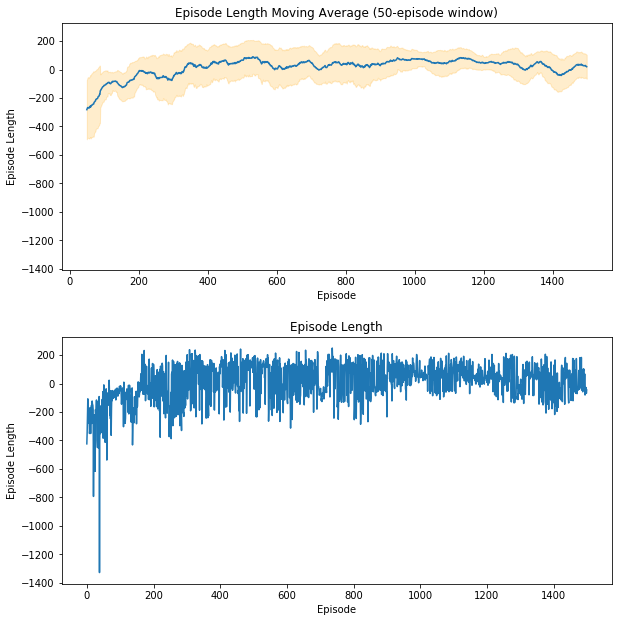

In [11]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

### Improving Exploration/Exploitation
In order to avoid the policy to conferge fast and stop exploring (Get stuck in local minima) in the environment, there is a trick called entropy bonus.
$$H(\pi)=-\sum{\pi_{\theta}(a|s).log\pi_{\theta}(a|s)}$$
This will simply show how much uncertain the policy is about it's actions. 
We just need to subtract the entropy bons from the loss function, forcing the policy to take more time to be certain and exploring more.

In [12]:
%%time
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

length_episode = []
rewards_episode = []
for episode in range(num_episodes):
    # Reset environment and record the starting state
    state = env.reset()

    for time in range(1000):
        # Get an action from the Policy and keep the historical data
        action = policy(state, keep_history=True)

        # Step through environment using chosen action
        state, reward, done, _ = env.step(action)

        # Save reward
        policy.episode_rewards.append(reward)
        rewards_episode.append(reward)
        if done:
            break

    # Calculate score to determine when the environment has been solved
    length_episode.append(time)
    mean_length_episode = np.mean(length_episode[-100:])
    mean_rewards_episode = np.mean(rewards_episode)
    
    # Calculate the discounted rewards on the episode, calculate loss and backpropagate
    update_policy(use_baseline=True, use_entropy=True)

    if episode % 50 == 0:
        print('Episode {}\tAverage length (last 100 episodes): {:.2f} Average Rewards {:.2f}'.format(
            episode, mean_length_episode, mean_rewards_episode))

    if mean_length_episode > env.spec.reward_threshold:
        print("Solved after {} episodes! Running average is now {}. Last episode ran to {} time steps."
              .format(episode, mean_length_episode, time))
        # Stop training after solving the environment
        #break

Episode 0	Average length (last 100 episodes): 71.00 Average Rewards -3.89
Episode 50	Average length (last 100 episodes): 101.59 Average Rewards -1.93
Episode 100	Average length (last 100 episodes): 164.87 Average Rewards -1.53
Solved after 116 episodes! Running average is now 200.97. Last episode ran to 999 time steps.
Solved after 117 episodes! Running average is now 210.02. Last episode ran to 999 time steps.
Solved after 118 episodes! Running average is now 219.15. Last episode ran to 999 time steps.
Solved after 119 episodes! Running average is now 220.17. Last episode ran to 223 time steps.
Solved after 120 episodes! Running average is now 224.8. Last episode ran to 527 time steps.
Solved after 121 episodes! Running average is now 226.02. Last episode ran to 221 time steps.
Solved after 122 episodes! Running average is now 226.56. Last episode ran to 156 time steps.
Solved after 123 episodes! Running average is now 234.9. Last episode ran to 999 time steps.
Solved after 124 episod

Solved after 201 episodes! Running average is now 352.63. Last episode ran to 172 time steps.
Solved after 202 episodes! Running average is now 350.77. Last episode ran to 121 time steps.
Solved after 203 episodes! Running average is now 350.53. Last episode ran to 205 time steps.
Solved after 204 episodes! Running average is now 358.14. Last episode ran to 999 time steps.
Solved after 205 episodes! Running average is now 357.48. Last episode ran to 130 time steps.
Solved after 206 episodes! Running average is now 356.59. Last episode ran to 168 time steps.
Solved after 207 episodes! Running average is now 362.88. Last episode ran to 999 time steps.
Solved after 208 episodes! Running average is now 359.47. Last episode ran to 167 time steps.
Solved after 209 episodes! Running average is now 357.11. Last episode ran to 129 time steps.
Solved after 210 episodes! Running average is now 356.33. Last episode ran to 180 time steps.
Solved after 211 episodes! Running average is now 355.56. La

Solved after 288 episodes! Running average is now 265.52. Last episode ran to 197 time steps.
Solved after 289 episodes! Running average is now 266.14. Last episode ran to 270 time steps.
Solved after 290 episodes! Running average is now 269.81. Last episode ran to 569 time steps.
Solved after 291 episodes! Running average is now 270.63. Last episode ran to 297 time steps.
Solved after 292 episodes! Running average is now 270.47. Last episode ran to 156 time steps.
Solved after 293 episodes! Running average is now 274.41. Last episode ran to 577 time steps.
Solved after 294 episodes! Running average is now 267.23. Last episode ran to 281 time steps.
Solved after 295 episodes! Running average is now 269.48. Last episode ran to 426 time steps.
Solved after 296 episodes! Running average is now 271.94. Last episode ran to 437 time steps.
Solved after 297 episodes! Running average is now 264.78. Last episode ran to 283 time steps.
Solved after 298 episodes! Running average is now 266.22. La

Solved after 375 episodes! Running average is now 279.84. Last episode ran to 128 time steps.
Solved after 376 episodes! Running average is now 277.52. Last episode ran to 146 time steps.
Solved after 377 episodes! Running average is now 274.82. Last episode ran to 116 time steps.
Solved after 378 episodes! Running average is now 272.66. Last episode ran to 178 time steps.
Solved after 379 episodes! Running average is now 274.47. Last episode ran to 604 time steps.
Solved after 380 episodes! Running average is now 276.52. Last episode ran to 740 time steps.
Solved after 381 episodes! Running average is now 277.65. Last episode ran to 629 time steps.
Solved after 382 episodes! Running average is now 274.65. Last episode ran to 101 time steps.
Solved after 383 episodes! Running average is now 273.6. Last episode ran to 209 time steps.
Solved after 384 episodes! Running average is now 272.24. Last episode ran to 177 time steps.
Solved after 385 episodes! Running average is now 268.93. Las

Solved after 462 episodes! Running average is now 292.04. Last episode ran to 171 time steps.
Solved after 463 episodes! Running average is now 294.73. Last episode ran to 413 time steps.
Solved after 464 episodes! Running average is now 296.04. Last episode ran to 268 time steps.
Solved after 465 episodes! Running average is now 298.72. Last episode ran to 368 time steps.
Solved after 466 episodes! Running average is now 300.59. Last episode ran to 313 time steps.
Solved after 467 episodes! Running average is now 302.81. Last episode ran to 304 time steps.
Solved after 468 episodes! Running average is now 306.0. Last episode ran to 496 time steps.
Solved after 469 episodes! Running average is now 308.54. Last episode ran to 323 time steps.
Solved after 470 episodes! Running average is now 310.2. Last episode ran to 323 time steps.
Solved after 471 episodes! Running average is now 312.33. Last episode ran to 321 time steps.
Solved after 472 episodes! Running average is now 312.95. Last

Solved after 551 episodes! Running average is now 201.16. Last episode ran to 85 time steps.
Episode 600	Average length (last 100 episodes): 113.31 Average Rewards -0.36
Episode 650	Average length (last 100 episodes): 118.25 Average Rewards -0.38
Episode 700	Average length (last 100 episodes): 145.42 Average Rewards -0.38
Episode 750	Average length (last 100 episodes): 187.50 Average Rewards -0.36
Solved after 756 episodes! Running average is now 201.15. Last episode ran to 261 time steps.
Solved after 757 episodes! Running average is now 202.38. Last episode ran to 210 time steps.
Solved after 758 episodes! Running average is now 206.32. Last episode ran to 496 time steps.
Solved after 759 episodes! Running average is now 208.21. Last episode ran to 286 time steps.
Solved after 760 episodes! Running average is now 210.06. Last episode ran to 267 time steps.
Solved after 761 episodes! Running average is now 212.04. Last episode ran to 275 time steps.
Solved after 762 episodes! Running 

Solved after 840 episodes! Running average is now 534.09. Last episode ran to 107 time steps.
Solved after 841 episodes! Running average is now 536.15. Last episode ran to 501 time steps.
Solved after 842 episodes! Running average is now 534.2. Last episode ran to 113 time steps.
Solved after 843 episodes! Running average is now 539.32. Last episode ran to 999 time steps.
Solved after 844 episodes! Running average is now 545.18. Last episode ran to 999 time steps.
Solved after 845 episodes! Running average is now 542.96. Last episode ran to 112 time steps.
Solved after 846 episodes! Running average is now 538.1. Last episode ran to 148 time steps.
Solved after 847 episodes! Running average is now 536.61. Last episode ran to 92 time steps.
Solved after 848 episodes! Running average is now 533.35. Last episode ran to 108 time steps.
Solved after 849 episodes! Running average is now 532.19. Last episode ran to 132 time steps.
Episode 850	Average length (last 100 episodes): 530.76 Average 

Solved after 926 episodes! Running average is now 339.33. Last episode ran to 222 time steps.
Solved after 927 episodes! Running average is now 334.8. Last episode ran to 546 time steps.
Solved after 928 episodes! Running average is now 326.7. Last episode ran to 189 time steps.
Solved after 929 episodes! Running average is now 327.22. Last episode ran to 171 time steps.
Solved after 930 episodes! Running average is now 335.72. Last episode ran to 999 time steps.
Solved after 931 episodes! Running average is now 335.72. Last episode ran to 999 time steps.
Solved after 932 episodes! Running average is now 341.09. Last episode ran to 999 time steps.
Solved after 933 episodes! Running average is now 341.81. Last episode ran to 238 time steps.
Solved after 934 episodes! Running average is now 341.81. Last episode ran to 999 time steps.
Solved after 935 episodes! Running average is now 347.76. Last episode ran to 969 time steps.
Solved after 936 episodes! Running average is now 348.41. Last

Solved after 1014 episodes! Running average is now 413.81. Last episode ran to 60 time steps.
Solved after 1015 episodes! Running average is now 404.92. Last episode ran to 110 time steps.
Solved after 1016 episodes! Running average is now 403.59. Last episode ran to 96 time steps.
Solved after 1017 episodes! Running average is now 403.04. Last episode ran to 75 time steps.
Solved after 1018 episodes! Running average is now 402.63. Last episode ran to 83 time steps.
Solved after 1019 episodes! Running average is now 400.27. Last episode ran to 120 time steps.
Solved after 1020 episodes! Running average is now 391.24. Last episode ran to 96 time steps.
Solved after 1021 episodes! Running average is now 382.2. Last episode ran to 95 time steps.
Solved after 1022 episodes! Running average is now 373.3. Last episode ran to 109 time steps.
Solved after 1023 episodes! Running average is now 368.06. Last episode ran to 108 time steps.
Solved after 1024 episodes! Running average is now 358.93.

Solved after 1429 episodes! Running average is now 341.42. Last episode ran to 456 time steps.
Solved after 1430 episodes! Running average is now 344.96. Last episode ran to 456 time steps.
Solved after 1431 episodes! Running average is now 347.7. Last episode ran to 371 time steps.
Solved after 1432 episodes! Running average is now 348.0. Last episode ran to 168 time steps.
Solved after 1433 episodes! Running average is now 353.61. Last episode ran to 629 time steps.
Solved after 1434 episodes! Running average is now 354.23. Last episode ran to 123 time steps.
Solved after 1435 episodes! Running average is now 358.76. Last episode ran to 554 time steps.
Solved after 1436 episodes! Running average is now 364.99. Last episode ran to 710 time steps.
Solved after 1437 episodes! Running average is now 367.59. Last episode ran to 409 time steps.
Solved after 1438 episodes! Running average is now 371.24. Last episode ran to 565 time steps.
Solved after 1439 episodes! Running average is now 3

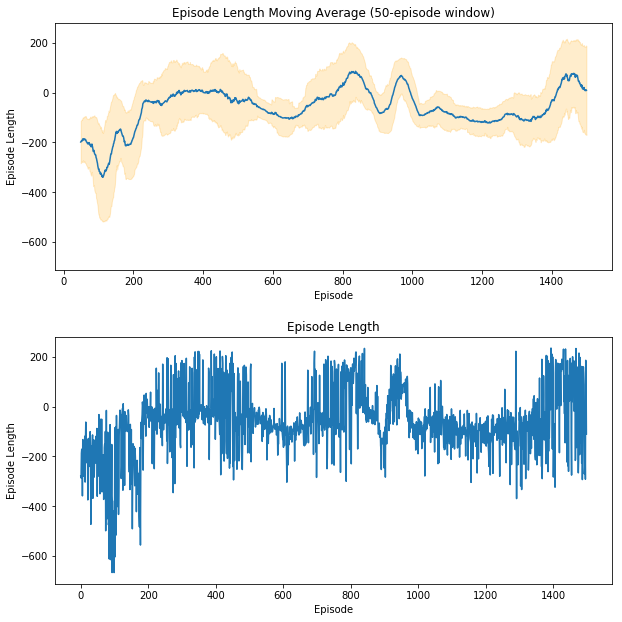

In [13]:
# number of episodes for rolling average
window = 50

# Create grid 2x1 plots
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9, 9])

# Calculate the mean of the rewards over time
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
# Calculate the standard deviation over time
std = pd.Series(policy.reward_history).rolling(window).std()

# Plot graph 1
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)), rolling_mean -
                 std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title(
    'Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode')
ax1.set_ylabel('Episode Length')

# Plot graph 2
ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

In [19]:
state = env.reset()

while True:
    action = policy(state)

    # Uncomment to render the visual state in a window
    env.render()

    # Step through environment using chosen action
    state, reward, done, _ = env.step(action)
    if done:
        break